Predictors for:

dino CM proportion
dino CM diversity (among other dinos)
CM proportion 
CM diversity (among all other ASVs?)

with env features, with pigment features?
with 18Sv4 and v9, can average results

**Objective: ranking features by how much they reduce sum of squared residuals on base estimators of best performing bagging models.**


Results:

Scatterplots and graphs tell the story: most of this data is zeroes. Can't tell anything meaningful with it, and it obscures patterns which could be found elsewhere. Start focusing on the data you actually want (drop the zeroes) and compare "diatom heavy" vs "dino CM heavy" samples: what's different, what's the same?

Inevitable result (?) of only considering a few hundred ASVs out of 34k+ in 18Sv4, etc. Would be more useful to do co-occurrence, community clustering, or other analyses with all available ASVs and then just extract the networks of known mixotrophs (the subgraphs centered on those ASVs). Even then, number of 0s may mean poor pairwise associations... could add counts for CMs together? 

Results:
Seeing how things turn out with the non-outlier samples brought back in: ust the same as adding a lot more zeroes, but doesn't really tell us anything.

Even though the whole point of this was to find out which variables are associated with a rise in CM proportion, sheer amount of zeroes (with very diverse environmental conditions) means that (for example) bagging can very easily lower MSE with trivial splits, and linear methods also have trouble (even with nonlinear methods, harder to get significant coefficients. PCA/RDA would find some vectors but nothing more interesting.

So instead we found a "comparable" group in the diatoms - are they really comparable metabolically? And with this group we confirm what should have been obvious before: there's no particular link of environmental variables to CM proportion except maybe season.

But now I have another question: are we even going to get a significant association of CM proportion with any of the environmental variables? Flashweave uses Aitchison/CLR for normalization. And "proportion" could just as easily represent a reduction in biomass overall... so maybe underlying community patterns don't really change, it's just that CMs are accompanied by fewer producers...
- Flashweave should be able to adjust pairwise mutual information when "probability" of CM achieving a particular count or log ratio is 0... so keep the zeroes, while marking the outliers: might be a useful metavariable
plan is: get the "neighbors" (highest association) of each (dino, otherwise) CM and of the metavariables. Then can add up those into a single category and track year/month flows, etc.

Tables which Flashweave needs: all-asv table (raw), and env_metadata with new variable


### Reading and preprocessing data

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor
%matplotlib inline

Import the following files: 

env_features with sample metadata.

pigment_features with sample metadata pertaining to pigments such as chlorophyll and peridinin.

response_features describing statistics such as CM percentage.

asv_freqs and asv_taxo_mft tables describing species frequencies. will use these to develop per-sample features relating CM and diatom frequencies.

In [12]:
asv_freqs_18Sv4 = pd.read_csv("01_out_asv_proportions_18Sv4.tsv", sep = "\t", index_col=0)
asv_freqs_18Sv9 = pd.read_csv("01_out_asv_proportions_18Sv9.tsv", sep = "\t", index_col=0)

env_features_18Sv4 = pd.read_csv("01_out_env_features_18Sv4.tsv", sep = "\t", index_col=0)
env_features_18Sv9 = pd.read_csv("01_out_env_features_18Sv9.tsv", sep = "\t", index_col=0)

#pigment_features_18Sv4 = pd.read_csv("_out_pigment_features_18Sv4.tsv", sep = "\t", index_col=0)
#pigment_features_18Sv9 = pd.read_csv("_out_pigment_features_18Sv9.tsv", sep = "\t", index_col=0)

#response_features_18Sv4 = pd.read_csv("_out_response_features_18Sv4.tsv", sep = "\t", index_col = 0)
#response_features_18Sv9 = pd.read_csv("_out_response_features_18Sv9.tsv", sep = "\t", index_col = 0)

In [13]:
#no longer recognizes missing values (such as empty strings) and replaces them with np.nan
asv_taxo_mft_18Sv4 = pd.read_csv("01_out_asv_taxo_mft_18Sv4.tsv", sep = "\t", index_col=0, na_filter=False)
asv_taxo_mft_18Sv9 = pd.read_csv("01_out_asv_taxo_mft_18Sv9.tsv", sep = "\t", index_col=0, na_filter=False)

### Creating response features

Use asv_taxo_mft to get lists of CM and lists of diatom ASVs. Then, add their frequencies within each sample.

In [14]:
#some of the MFTs are NaN... replace with ""?
CM_asvs_18Sv4 = asv_taxo_mft_18Sv4.loc[ asv_taxo_mft_18Sv4["MFT"].str.match("CM") ].index
CM_asvs_18Sv9 = asv_taxo_mft_18Sv9.loc[ asv_taxo_mft_18Sv9["MFT"].str.match("CM") ].index

diatom_asvs_18Sv4 = asv_taxo_mft_18Sv4.loc[ asv_taxo_mft_18Sv4['Taxon'].str.contains("Bacillariophyceae") ].index
diatom_asvs_18Sv9 = asv_taxo_mft_18Sv9.loc[ asv_taxo_mft_18Sv9['Taxon'].str.contains("Bacillariophyceae") ].index

CM_asvs_18Sv4.size, CM_asvs_18Sv9.size, diatom_asvs_18Sv4.size, diatom_asvs_18Sv9.size

(473, 450, 263, 268)

In [15]:
asv_taxo_mft_18Sv4.loc[CM_asvs_18Sv4, "MFT"].value_counts()

CM    473
Name: MFT, dtype: int64

In [16]:
CM_asv_freqs_18Sv4 = asv_freqs_18Sv4.loc[CM_asvs_18Sv4].apply(sum, axis = 0)
CM_asv_freqs_18Sv9 = asv_freqs_18Sv9.loc[CM_asvs_18Sv9].apply(sum, axis = 0)

diatom_asv_freqs_18Sv4 = asv_freqs_18Sv4.loc[diatom_asvs_18Sv4].apply(sum, axis = 0)
diatom_asv_freqs_18Sv9 = asv_freqs_18Sv9.loc[diatom_asvs_18Sv9].apply(sum, axis = 0)

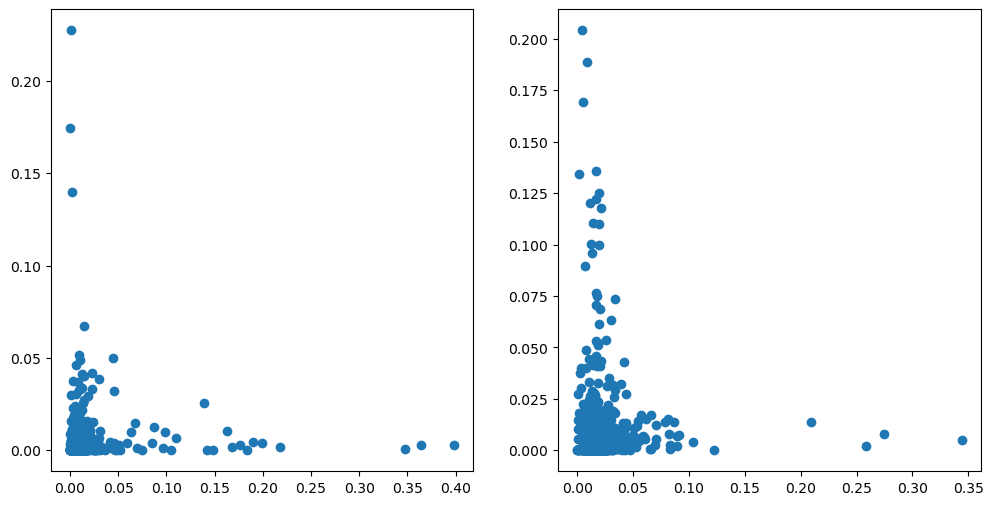

In [17]:
MLD_samples_18Sv4 = env_features_18Sv4.loc[ env_features_18Sv4["Bottle_Depth"] <= env_features_18Sv4["MLD_Sigma"] ].index
MLD_samples_18Sv9 = env_features_18Sv9.loc[ env_features_18Sv9["Bottle_Depth"] <= env_features_18Sv9["MLD_Sigma"] ].index

fig,ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)
ax[0].scatter(CM_asv_freqs_18Sv4.loc[MLD_samples_18Sv4], diatom_asv_freqs_18Sv4.loc[MLD_samples_18Sv4])
ax[1].scatter(CM_asv_freqs_18Sv9.loc[MLD_samples_18Sv9], diatom_asv_freqs_18Sv9.loc[MLD_samples_18Sv9])
plt.show()

Deep water (Bottle Depth < MLD_Sigma) samples: 18Sv4 and 18Sv9 datasets show different levels of capture for CMs and diatoms, it's hard to think that both of these outcomes represent the same microbial communities. Possible biases with primers used, capture methods, or taxonomies?

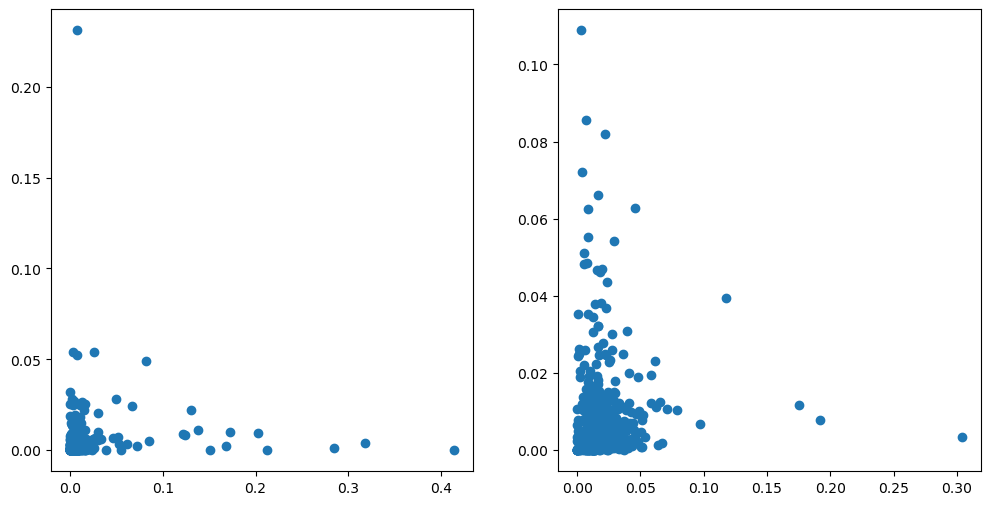

In [18]:
fig,ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)
ax[0].scatter(CM_asv_freqs_18Sv4.drop(MLD_samples_18Sv4), diatom_asv_freqs_18Sv4.drop(MLD_samples_18Sv4))
ax[1].scatter(CM_asv_freqs_18Sv9.drop(MLD_samples_18Sv9), diatom_asv_freqs_18Sv9.drop(MLD_samples_18Sv9))
plt.show()

In [19]:
def outliers(series):
    q3 = np.quantile(series, 0.75)
    IQR = q3 - np.quantile(series, 0.25)
    return series.loc[ series > (q3 + (1.5 * IQR)) ].index

#samples in which there is an outlier amount of diatoms and/or CMs.
#includes only the shallow water samples!
all_outliers_18Sv4 = pd.concat([pd.Series(outliers(CM_asv_freqs_18Sv4.loc[MLD_samples_18Sv4])),
                                pd.Series(outliers(diatom_asv_freqs_18Sv4.loc[MLD_samples_18Sv4]))])
all_outliers_18Sv9 = pd.concat([pd.Series(outliers(CM_asv_freqs_18Sv9.loc[MLD_samples_18Sv9])),
                                pd.Series(outliers(diatom_asv_freqs_18Sv9.loc[MLD_samples_18Sv9]))])

In [20]:
sum(all_outliers_18Sv4.apply(lambda x: CM_asv_freqs_18Sv4[x] > diatom_asv_freqs_18Sv4[x])),\
sum(all_outliers_18Sv4.apply(lambda x: CM_asv_freqs_18Sv4[x] <= diatom_asv_freqs_18Sv4[x]))

(77, 54)

In [21]:
sum(all_outliers_18Sv9.apply(lambda x: CM_asv_freqs_18Sv9[x] > diatom_asv_freqs_18Sv9[x])),\
sum(all_outliers_18Sv9.apply(lambda x: CM_asv_freqs_18Sv9[x] <= diatom_asv_freqs_18Sv9[x]))

(70, 75)

In [22]:
#includes only samples above MLD
CM_outliers_18Sv4 = all_outliers_18Sv4[all_outliers_18Sv4.apply(lambda x: CM_asv_freqs_18Sv4[x] > diatom_asv_freqs_18Sv4[x])]
diatom_outliers_18Sv4 = all_outliers_18Sv4[all_outliers_18Sv4.apply(lambda x: CM_asv_freqs_18Sv4[x] <= diatom_asv_freqs_18Sv4[x])]

CM_outliers_18Sv9 = all_outliers_18Sv9[all_outliers_18Sv9.apply(lambda x: CM_asv_freqs_18Sv9[x] > diatom_asv_freqs_18Sv9[x])]
diatom_outliers_18Sv9 = all_outliers_18Sv9[all_outliers_18Sv9.apply(lambda x: CM_asv_freqs_18Sv9[x] <= diatom_asv_freqs_18Sv9[x])]

In [23]:
CM_outliers_18Sv4.size, diatom_outliers_18Sv4.size,\
CM_outliers_18Sv9.size, CM_outliers_18Sv9.size

(77, 54, 70, 70)

Difference in monthly distribution? on every other variable, seem very similar. Most outliers are from noon for example. Also differ in year... Problem is, month is not itself a biogeochemical variable -- so what's the actual difference here...
- light exposure (FvFm? check other metadata or Datazoo?)
- presence of prey... co-occurrence, or occurrence after a lag. can treat CM-dominant or diatom-dominant as per-sample metavariable, after confirming which variables exactly have a significant difference. Does co-occurrence network's treatment of metavariables distinguish between particular values of variables?

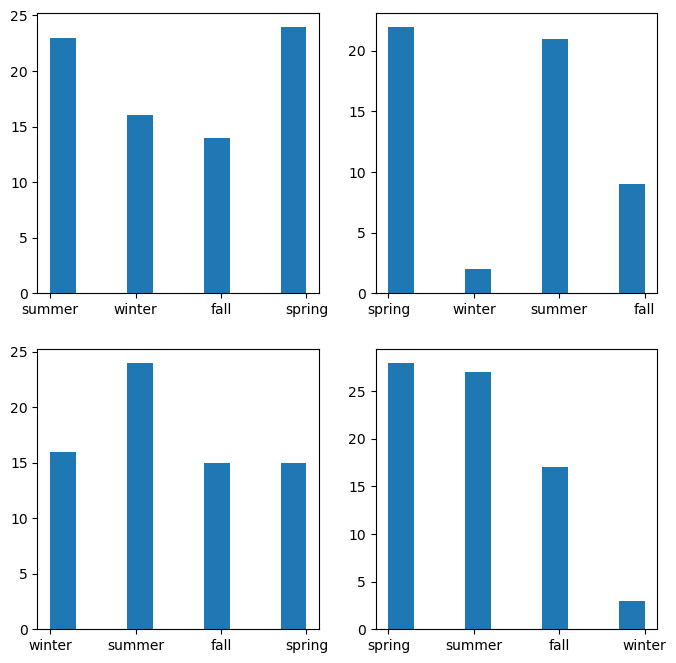

In [24]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)

ax[0][0].hist(env_features_18Sv4.loc[CM_outliers_18Sv4, "season"])
ax[0][1].hist(env_features_18Sv4.loc[diatom_outliers_18Sv4, "season"])
ax[1][0].hist(env_features_18Sv9.loc[CM_outliers_18Sv9, "season"])
ax[1][1].hist(env_features_18Sv9.loc[diatom_outliers_18Sv9, "season"])
plt.show()

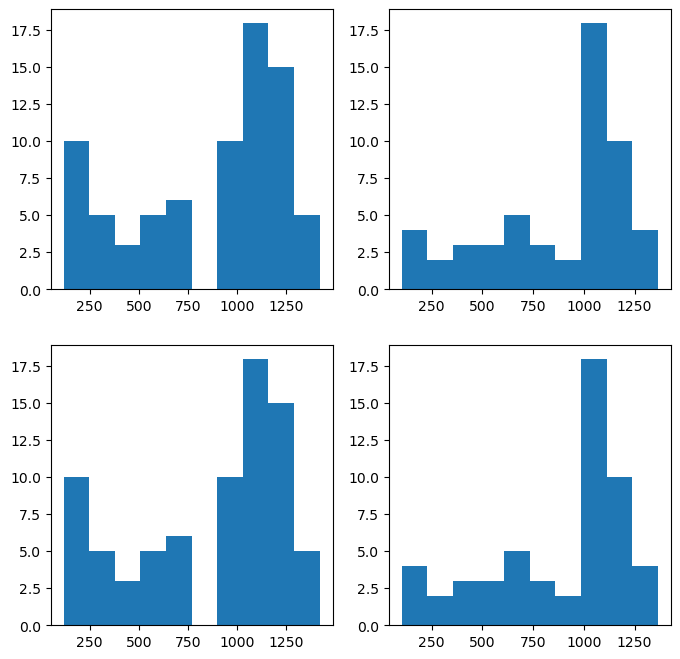

In [25]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
ax[0][0].hist(env_features_18Sv4.loc[CM_outliers_18Sv4, "Mins_since_0000"])
ax[0][1].hist(env_features_18Sv4.loc[diatom_outliers_18Sv4, "Mins_since_0000"])
ax[1][0].hist(env_features_18Sv9.loc[CM_outliers_18Sv4, "Mins_since_0000"])
ax[1][1].hist(env_features_18Sv9.loc[diatom_outliers_18Sv4, "Mins_since_0000"])
plt.show()

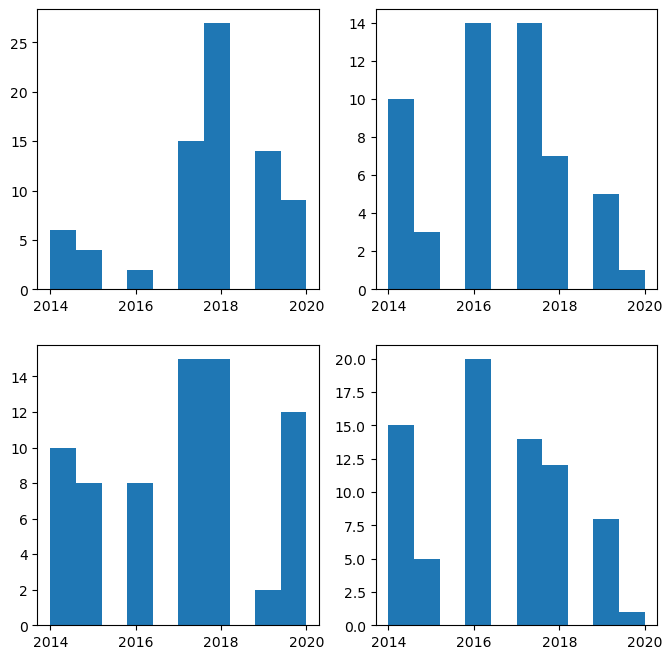

In [26]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
ax[0][0].hist(env_features_18Sv4.loc[CM_outliers_18Sv4, "year"])
ax[0][1].hist(env_features_18Sv4.loc[diatom_outliers_18Sv4, "year"])
ax[1][0].hist(env_features_18Sv9.loc[CM_outliers_18Sv9, "year"])
ax[1][1].hist(env_features_18Sv9.loc[diatom_outliers_18Sv9, "year"])
plt.show()

Biogeochemical variables: more spread in ammonia in the CM dominant samples rather than diatom...

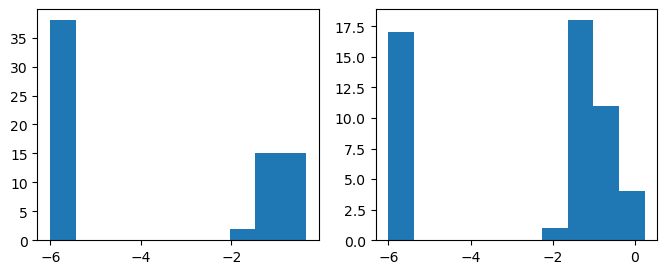

In [27]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(3)
fig.set_figwidth(8)
ax[0].hist(env_features_18Sv4.loc[CM_outliers_18Sv4, "NH3ug"].apply(lambda x: np.log10(x + 1e-6)))
ax[1].hist(env_features_18Sv4.loc[diatom_outliers_18Sv4, "NH3ug"].apply(lambda x: np.log10(x + 1e-6)))
plt.show()

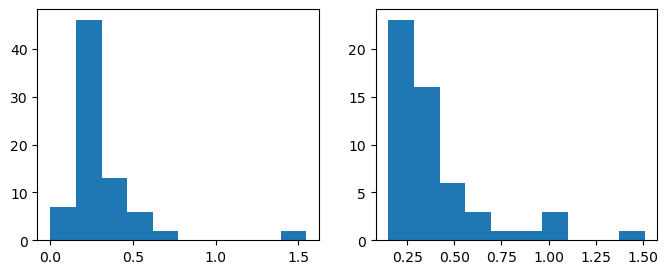

In [28]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(3)
fig.set_figwidth(8)
ax[0].hist(env_features_18Sv4.loc[CM_outliers_18Sv4, "PO4ug"])
ax[1].hist(env_features_18Sv4.loc[diatom_outliers_18Sv4, "PO4ug"])
plt.show()

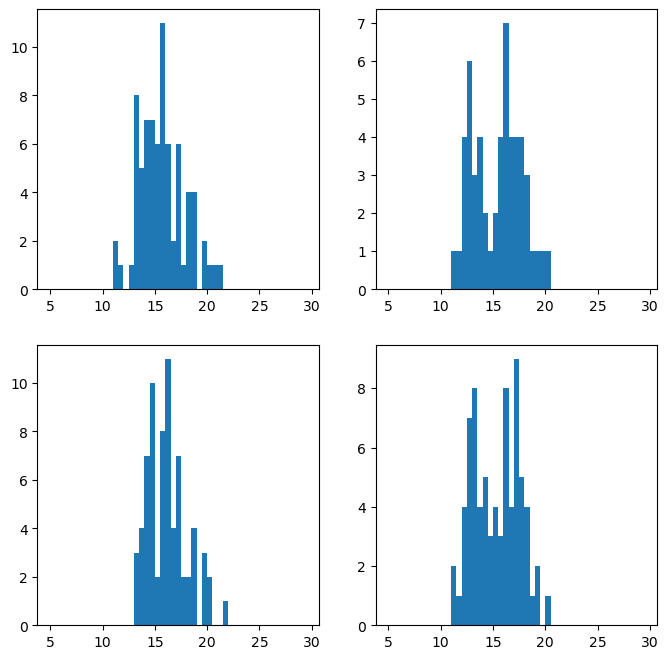

In [29]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
ax[0][0].hist(env_features_18Sv4.loc[CM_outliers_18Sv4, "T_degC"], bins = np.arange(5,30, 0.5))
ax[0][1].hist(env_features_18Sv4.loc[diatom_outliers_18Sv4, "T_degC"], bins = np.arange(5,30, 0.5))
ax[1][0].hist(env_features_18Sv9.loc[CM_outliers_18Sv9, "T_degC"], bins = np.arange(5,30, 0.5))
ax[1][1].hist(env_features_18Sv9.loc[diatom_outliers_18Sv9, "T_degC"], bins = np.arange(5,30, 0.5))
plt.show()

### Chi square contingency tests for season

In [30]:
#scipy version 1.10.0, missing some functionality relative to docs (1.14.0)
from scipy.stats import shapiro, chisquare, chi2_contingency

In [31]:
#chi squared assumptions: independence of observations (no relationship between observations in different groups)
#and at least 5 observations per category... except i'll have zeroes. can also fuse groups, at that point
#should just use "season".

#or - 4 fishers exact tests, one for each season?

CM_dom_season_18Sv4 = env_features_18Sv4.loc[CM_outliers_18Sv4, "season"]
CM_dom_season_18Sv9 = env_features_18Sv9.loc[CM_outliers_18Sv9, "season"]
diatom_dom_season_18Sv4 = env_features_18Sv4.loc[diatom_outliers_18Sv4, "season"]
diatom_dom_season_18Sv9 = env_features_18Sv9.loc[diatom_outliers_18Sv9, "season"]

season_order = ["winter", "spring", "summer", "fall"]
CM_season_observed_freqs_18Sv4 = CM_dom_season_18Sv4.value_counts().loc[season_order]
CM_season_expected_freqs_18Sv4 = ((diatom_dom_season_18Sv4.value_counts() / diatom_dom_season_18Sv4.size)\
                                    *  CM_dom_season_18Sv4.size).loc[season_order]

CM_season_observed_freqs_18Sv9 = CM_dom_season_18Sv9.value_counts().loc[season_order]
CM_season_expected_freqs_18Sv9 = ((diatom_dom_season_18Sv9.value_counts() / diatom_dom_season_18Sv9.size)\
                                    *  CM_dom_season_18Sv9.size).loc[season_order]
#diatom_season_frequencies_18Sv4 = (diatom_dom_season_18Sv4.value_counts() / diatom_dom_season_18Sv4.size).loc[season_order]
#diatom_season_frequencies_18Sv9 = (diatom_dom_season_18Sv9.value_counts() / diatom_dom_season_18Sv9.size).loc[season_order]

In [32]:
CM_season_observed_freqs_18Sv4, CM_season_expected_freqs_18Sv4

(winter    16
 spring    24
 summer    23
 fall      14
 Name: season, dtype: int64,
 winter     2.851852
 spring    31.370370
 summer    29.944444
 fall      12.833333
 Name: season, dtype: float64)

In [33]:
CM_season_observed_freqs_18Sv9, CM_season_expected_freqs_18Sv9

(winter    16
 spring    15
 summer    24
 fall      15
 Name: season, dtype: int64,
 winter     2.800000
 spring    26.133333
 summer    25.200000
 fall      15.866667
 Name: season, dtype: float64)

scipy.stats.chisquare expects to receive frequencies, not proportions.

Goodness of fit tests: p < 0.001, CM seasonal distribution does not match diatom seasonal distribution in either dataset.

**Contingency/independence test: expected frequencies based on marginal sums: expected (r,c) = sum_r * (sum_c / total). Again the distributions are different. "CM dominated samples" from winter. Does this translate to higher moving averages in winter months? Can this be displayed on a graph by month?**

In [34]:
#not enough degrees of freedom? make sure test is being performed correctly.
chisquare(f_obs=CM_season_observed_freqs_18Sv4, f_exp = CM_season_expected_freqs_18Sv4)

Power_divergenceResult(statistic=64.06628436498568, pvalue=7.944466745361376e-14)

In [35]:
#not enough degrees of freedom? make sure test is being performed correctly.
chisquare(f_obs=CM_season_observed_freqs_18Sv9, f_exp = CM_season_expected_freqs_18Sv9)

Power_divergenceResult(statistic=67.07608043217286, pvalue=1.803739489310855e-14)

In [36]:
contingency_table_18Sv4 = pd.DataFrame({
    "CM-dominated": CM_season_observed_freqs_18Sv4,
    "diatom-dominated": diatom_dom_season_18Sv4.value_counts().loc[season_order]
}, index = season_order).transpose()
contingency_table_18Sv9 = pd.DataFrame({
    "CM-dominated": CM_season_observed_freqs_18Sv9,
    "diatom-dominated": diatom_dom_season_18Sv9.value_counts().loc[season_order]
}, index = season_order).transpose()
contingency_table_18Sv9

,winter,spring,summer,fall
CM-dominated,16,15,24,15
diatom-dominated,3,28,27,17


In [37]:
chi2_contingency(contingency_table_18Sv4)

Chi2ContingencyResult(statistic=8.373667320252743, pvalue=0.038888547209636595, dof=3, expected_freq=array([[10.58015267, 27.03816794, 25.86259542, 13.51908397],
       [ 7.41984733, 18.96183206, 18.13740458,  9.48091603]]))

In [38]:
chi2_contingency(contingency_table_18Sv9)

Chi2ContingencyResult(statistic=12.969447655133044, pvalue=0.004703144636594256, dof=3, expected_freq=array([[ 9.17241379, 20.75862069, 24.62068966, 15.44827586],
       [ 9.82758621, 22.24137931, 26.37931034, 16.55172414]]))

### Chi 2 contigency tests for year

Not sure how you'd implement p-value correction but: one test (18Sv9) fails flat out. 18Sv4 has a low p value, probably still lower than any corrected threshold. So I at least have a reason for why I'm only going to investigate winter from here on out.

In [39]:
year_order = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
year_contingency_table_18Sv4 = pd.DataFrame({
    "CM_dominated" : env_features_18Sv4.loc[CM_outliers_18Sv4, "year"].value_counts().loc[year_order],
    "diatom_dominated" : env_features_18Sv4.loc[diatom_outliers_18Sv4, "year"].value_counts().loc[year_order]
})
year_contingency_table_18Sv4.index = [str(year) for year in year_order]
#merge 2014-15, 2019-20
display(year_contingency_table_18Sv4)
year_contingency_table_18Sv4.loc["2014-15"] = year_contingency_table_18Sv4.loc["2014"]\
                                                + year_contingency_table_18Sv4.loc["2015"]
year_contingency_table_18Sv4.loc["2019-20"] = year_contingency_table_18Sv4.loc["2019"]\
                                                + year_contingency_table_18Sv4.loc["2020"]
year_contingency_table_18Sv4 = year_contingency_table_18Sv4.drop(["2014", "2015", "2019", "2020"]).sort_index()
display(year_contingency_table_18Sv4)
chi2_contingency(year_contingency_table_18Sv4)

,CM_dominated,diatom_dominated
2014,6,10
2015,4,3
2016,2,14
2017,15,14
2018,27,7
2019,14,5
2020,9,1


,CM_dominated,diatom_dominated
2014-15,10,13
2016,2,14
2017,15,14
2018,27,7
2019-20,23,6


Chi2ContingencyResult(statistic=27.980356635407787, pvalue=1.2587791907974102e-05, dof=4, expected_freq=array([[13.51908397,  9.48091603],
       [ 9.40458015,  6.59541985],
       [17.04580153, 11.95419847],
       [19.98473282, 14.01526718],
       [17.04580153, 11.95419847]]))

In [40]:
year_order = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
year_contingency_table_18Sv9 = pd.DataFrame([], index = year_order)
year_contingency_table_18Sv9["CM_dominated"] = [
    sum(env_features_18Sv9.loc[CM_outliers_18Sv9, "year"] == x) for x in year_order
]
year_contingency_table_18Sv9["diatom_dominated"] = [
    sum(env_features_18Sv9.loc[diatom_outliers_18Sv9, "year"] == x) for x in year_order
]

year_contingency_table_18Sv9.index = [str(year) for year in year_order]
display(year_contingency_table_18Sv9)
#which cols need merging? merge 2014-15, 2019-20 again

year_contingency_table_18Sv9_merge1 = year_contingency_table_18Sv9.copy()

year_contingency_table_18Sv9_merge1.loc["2014-15"] = year_contingency_table_18Sv9_merge1.loc["2014"]\
                                                + year_contingency_table_18Sv9_merge1.loc["2015"]
year_contingency_table_18Sv9_merge1.loc["2019-20"] = year_contingency_table_18Sv9_merge1.loc["2019"]\
                                                + year_contingency_table_18Sv9_merge1.loc["2020"]
year_contingency_table_18Sv9_merge1 = \
    year_contingency_table_18Sv9_merge1.drop(["2014", "2015", "2019", "2020"]).sort_index()
display(year_contingency_table_18Sv9_merge1)
print(chi2_contingency(year_contingency_table_18Sv9_merge1))

#do results change if you merge 2015-2016?
year_contingency_table_18Sv9_merge2 = year_contingency_table_18Sv9.copy()

year_contingency_table_18Sv9_merge2.loc["2015-16"] = year_contingency_table_18Sv9_merge2.loc["2015"]\
                                                + year_contingency_table_18Sv9_merge2.loc["2016"]
year_contingency_table_18Sv9_merge2.loc["2019-20"] = year_contingency_table_18Sv9_merge2.loc["2019"]\
                                                + year_contingency_table_18Sv9_merge2.loc["2020"]
year_contingency_table_18Sv9_merge2 = \
    year_contingency_table_18Sv9_merge2.drop(["2015", "2016", "2019", "2020"]).sort_index()
display(year_contingency_table_18Sv9_merge2)
print(chi2_contingency(year_contingency_table_18Sv9_merge2))

,CM_dominated,diatom_dominated
2014,10,15
2015,8,5
2016,8,20
2017,15,14
2018,15,12
2019,2,8
2020,12,1


,CM_dominated,diatom_dominated
2014-15,18,20
2016,8,20
2017,15,14
2018,15,12
2019-20,14,9


Chi2ContingencyResult(statistic=6.538253501247943, pvalue=0.16239600483146222, dof=4, expected_freq=array([[18.34482759, 19.65517241],
       [13.51724138, 14.48275862],
       [14.        , 15.        ],
       [13.03448276, 13.96551724],
       [11.10344828, 11.89655172]]))


,CM_dominated,diatom_dominated
2014,10,15
2015-16,16,25
2017,15,14
2018,15,12
2019-20,14,9


Chi2ContingencyResult(statistic=4.263037586897606, pvalue=0.3715764424139803, dof=4, expected_freq=array([[12.06896552, 12.93103448],
       [19.79310345, 21.20689655],
       [14.        , 15.        ],
       [13.03448276, 13.96551724],
       [11.10344828, 11.89655172]]))


In [41]:
assert(False)

AssertionError: 

### Prototyping a "moving average over time" graph

Starting from "outlier samples", want to show how CM/diatom distributions change by month, and eventually bring other species in (co-correlates of CMs/diatoms, high pairwise interaction, etc).

An assumption that went unstated earlier: it was simply assumed that the number of "X-dominated outlier" samples in a particular season would correspond to higher per-sample proportions (within those same samples) for X... this is reasonable since outliers are tagged as CM-dominated or diatom-dominated on the basis that they have more of one or the other.

Omitting missing values works! (getting rid of low proportions) can see if this remains under different normalization methods (CPL, etc.)

"Fill between" with a version of 95% CI? Which distribution should CI be designed according to? or bootstrap (but with such little variation...)

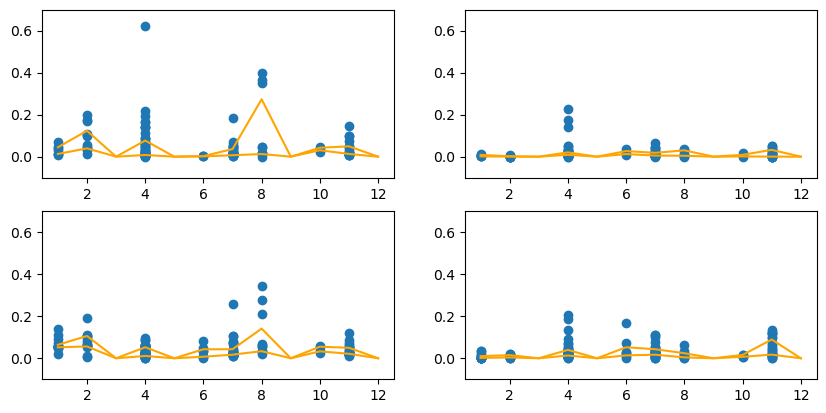

In [72]:
#two different ways to access and modify plots: plt, or fig/ax.
#interesting distribution where I'm pretty sure most samples have 0 or close ot 0 of both, then a few have more of 
#one or the other.
fig, ax = plt.subplots(2,2)
fig.set_figwidth(10)

#select all outliers, graph them by month
months = np.arange(1,13,1)

def generate_line(asv_freqs, outlier_samples, env_features, function):
    medians = []
    sample_months = env_features.loc[ outlier_samples, "month" ]
    for month in months:
        outlier_asv_freqs_per_month = asv_freqs.loc[ outlier_samples ].loc[ sample_months == month ]
        if outlier_asv_freqs_per_month.size == 0:
            medians.append(0)
            continue
        medians.append(function(outlier_asv_freqs_per_month))
    return medians
    

ax[0][0].scatter(env_features_18Sv4.loc[ all_outliers_18Sv4, "month" ],
              CM_asv_freqs_18Sv4.loc[ all_outliers_18Sv4.values ])
ax[0][0].plot(months, generate_line(CM_asv_freqs_18Sv4, all_outliers_18Sv4, 
                                      env_features_18Sv4, lambda x: np.quantile(x, 0.25)), color = "orange")
ax[0][0].plot(months, generate_line(CM_asv_freqs_18Sv4, all_outliers_18Sv4, 
                                      env_features_18Sv4, lambda x: np.quantile(x, 0.75)), color = "orange")
              
ax[0][1].scatter(env_features_18Sv4.loc[ all_outliers_18Sv4, "month" ], 
              diatom_asv_freqs_18Sv4.loc[ all_outliers_18Sv4 ])
ax[0][1].plot(months, generate_line(diatom_asv_freqs_18Sv4, all_outliers_18Sv4, 
                                    env_features_18Sv4, lambda x: np.quantile(x, 0.25)), color = "orange")
ax[0][1].plot(months, generate_line(diatom_asv_freqs_18Sv4, all_outliers_18Sv4, 
                                    env_features_18Sv4, lambda x: np.quantile(x, 0.75)), color = "orange")

ax[1][0].scatter(env_features_18Sv9.loc[ all_outliers_18Sv9, "month" ], 
              CM_asv_freqs_18Sv9.loc[ all_outliers_18Sv9 ])
ax[1][0].plot(months, generate_line(CM_asv_freqs_18Sv9, all_outliers_18Sv9, 
                                    env_features_18Sv9, lambda x: np.quantile(x, 0.25)), color = "orange")
ax[1][0].plot(months, generate_line(CM_asv_freqs_18Sv9, all_outliers_18Sv9, 
                                    env_features_18Sv9, lambda x: np.quantile(x, 0.75)), color = "orange")


ax[1][1].scatter(env_features_18Sv9.loc[ all_outliers_18Sv9, "month" ], 
              diatom_asv_freqs_18Sv9.loc[ all_outliers_18Sv9 ])
ax[1][1].plot(months, generate_line(diatom_asv_freqs_18Sv9, all_outliers_18Sv9, 
                                      env_features_18Sv9, lambda x: np.quantile(x, 0.25)), color = "orange")
ax[1][1].plot(months, generate_line(diatom_asv_freqs_18Sv9, all_outliers_18Sv9, 
                                      env_features_18Sv9, lambda x: np.quantile(x, 0.75)), color = "orange")


for sub_ax in ax.flatten():
    sub_ax.set_ybound(lower = -0.1, upper = 0.7)
plt.show()

In [60]:
[CM_asv_freqs_18Sv4.loc[ all_outliers_18Sv4.values ].loc[ sample_months_18Sv4 == month ]
 for month in months]

[X201501_080.0_055.0_10    0.042297
 X201501_083.3_042.0_9     0.033331
 X201601_093.3_026.7_10    0.070270
 X202001_080.0_051.0_28    0.046972
 X201701_080.0_100.0_10    0.011194
 X201701_080.0_100.0_30    0.014752
 X202001_086.7_060.0_43    0.008105
 dtype: float64,
 X201802_076.7_051.0_10    0.104784
 X201802_076.7_055.0_10    0.168795
 X201802_076.7_060.0_10    0.046406
 X201802_080.0_060.0_10    0.035708
 X201802_083.3_040.6_10    0.176726
 X201802_083.3_042.0_10    0.199379
 X201802_083.3_090.0_10    0.108250
 X201802_090.0_028.0_10    0.096979
 X201802_090.0_035.0_10    0.040970
 X201802_090.0_060.0_10    0.054311
 X201802_090.0_100.0_10    0.033034
 X201402_090.0_053.0_10    0.011987
 dtype: float64,
 Series([], dtype: float64),
 X201604_080.0_100.0_10    0.623663
 X201604_093.3_026.7_9     0.057999
 X201704_066.7_055.0_10    0.046804
 X201804_080.0_070.0_9     0.191341
 X201804_080.0_080.0_10    0.111335
 X201804_083.3_060.0_10    0.163377
 X201804_086.7_050.0_14    0.033023
 

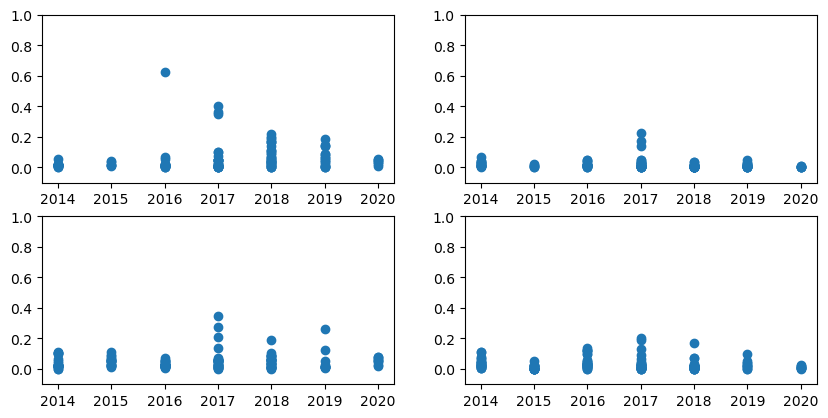

In [51]:
#two different ways to access and modify plots: plt, or fig/ax.
#interesting distribution where I'm pretty sure most samples have 0 or close ot 0 of both, then a few have more of 
#one or the other.
fig, ax = plt.subplots(2,2)
fig.set_figwidth(10)

#select all outliers, graph them by month
months = np.arange(1,13,1)
ax[0][0].scatter(env_features_18Sv4.loc[ all_outliers_18Sv4, "year" ],
              CM_asv_freqs_18Sv4.loc[ all_outliers_18Sv4.values ])
ax[0][1].scatter(env_features_18Sv4.loc[ all_outliers_18Sv4, "year" ], 
              diatom_asv_freqs_18Sv4.loc[ all_outliers_18Sv4 ])
ax[1][0].scatter(env_features_18Sv9.loc[ all_outliers_18Sv9, "year" ], 
              CM_asv_freqs_18Sv9.loc[ all_outliers_18Sv9 ])
ax[1][1].scatter(env_features_18Sv9.loc[ all_outliers_18Sv9, "year" ], 
              diatom_asv_freqs_18Sv9.loc[ all_outliers_18Sv9 ])
for sub_ax in ax.flatten():
    sub_ax.set_ybound(lower = -0.1, upper = 1)
plt.show()

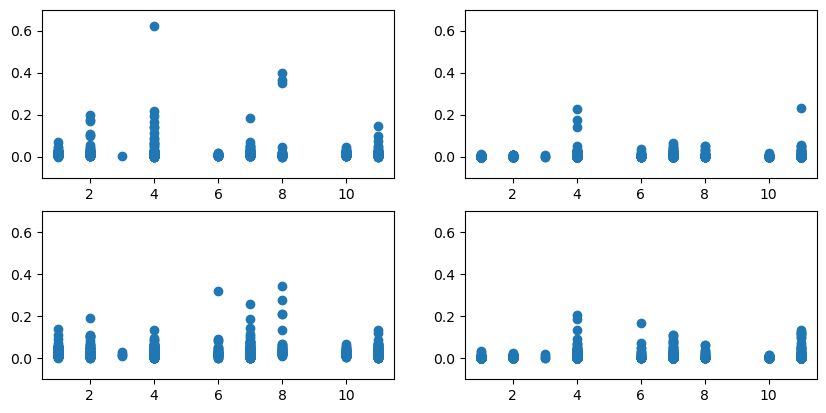

In [120]:
#including all samples, not just the outliers
ax[0][0].scatter(env_features_18Sv4.loc[MLD_samples_18Sv4, "month"], CM_asv_freqs_18Sv4.loc[MLD_samples_18Sv4])

ax[0][1].scatter(env_features_18Sv4["month"], diatom_asv_freqs_18Sv4)

ax[1][0].scatter(env_features_18Sv9["month"], CM_asv_freqs_18Sv9)

ax[1][1].scatter(env_features_18Sv9["month"], diatom_asv_freqs_18Sv9)

for sub_ax in ax.flatten():
    sub_ax.set_ybound(lower = -0.1, upper = 0.7)
plt.show()

### welch-t or mann whitney for the numerical variables

welch-t has assumption of normal distribution, would guess that many of these variables aren't even lognormal (too many zeroes). mann whitney it is.

In [20]:
env_features_18Sv4.columns

Index(['Cast_Type', 'Cardinal_Sta', 'Lat_Dec', 'Lon_Dec', 'Bottle_Depth',
       'T_degC', 'Salnty', 'STheta', 'O2ml_L', 'PO4ug', 'SiO3ug', 'NO3ug',
       'NH3ug', 'ChlorA', 'Phaeop', 'RecInd', 'MLD_Sigma', 'year', 'month',
       'season', 'Mins_since_0000'],
      dtype='object')

In [22]:
def test_normality(column, verbose = False):
    test_stat, pval = shapiro(x=column.dropna())
    if verbose:
        print(f"""Variable {column.name} with {column.size - sum(column.isna())} observations: 
        Test stat {test_stat}, pvalue {pval}""")
    return pval >= 0.05

relevant_columns = env_features_18Sv4.select_dtypes(include=np.float64).columns.drop(["RecInd"])

pd.DataFrame({
    "is_normal_CM_18Sv4" :
    env_features_18Sv4.loc[CM_outliers_18Sv4, relevant_columns].apply(test_normality),
    "is_normal_diatom_18Sv4" :
    env_features_18Sv4.loc[diatom_outliers_18Sv4, relevant_columns].apply(test_normality),
    "is_normal_CM_18Sv9" :
    env_features_18Sv9.loc[CM_outliers_18Sv9, relevant_columns].apply(test_normality),
    "is_normal_diatom_18Sv9" :
    env_features_18Sv9.loc[diatom_outliers_18Sv9, relevant_columns].apply(test_normality),
})

,is_normal_CM_18Sv4,is_normal_diatom_18Sv4,is_normal_CM_18Sv9,is_normal_diatom_18Sv9
Lat_Dec,False,False,False,False
Lon_Dec,False,True,False,True
Bottle_Depth,False,False,False,False
T_degC,True,True,False,False
Salnty,False,True,False,False
STheta,True,True,True,True
O2ml_L,False,False,False,False
PO4ug,False,False,False,False
SiO3ug,False,False,False,False
NO3ug,False,False,False,False


### Preparing tables for Flashweave.

leave out non-MLD samples.

"NOTE: OTU table and metadata table must be aligned such that each row corresponds to the same sample in both files (i.e. sample 1 data is found in row 1 in both files, etc.)."

leave sample ID in, it has only been removed from the "tiny" examples, is present in the "small".

"Meta variables containing string factors with more than two categories are automatically one-hot encoded by FlashWeave prior to network inference to increase the reliability and interpretability of statistical tests (the user will be notified if this happens)."

See the "attack" notebook from michael for how graph output becomes readable, esp. in python.

In [125]:
env_features_18Sv4["MixedLayer_Outlier"] = ""
env_features_18Sv4.loc[CM_outliers_18Sv4, "MixedLayer_Outlier"] = "CM_dominated"
env_features_18Sv4.loc[diatom_outliers_18Sv4, "MixedLayer_Outlier"] = "diatom_dominated"
env_features_18Sv4.loc[MLD_samples_18Sv4].to_csv("02_out_env_features_18Sv4.tsv", sep = "\t")

env_features_18Sv9["MixedLayer_Outlier"] = ""
env_features_18Sv9.loc[CM_outliers_18Sv9, "MixedLayer_Outlier"] = "CM_dominated"
env_features_18Sv9.loc[diatom_outliers_18Sv9, "MixedLayer_Outlier"] = "diatom_dominated"
env_features_18Sv9.loc[MLD_samples_18Sv9].to_csv("02_out_env_features_18Sv9.tsv", sep = "\t")

In [130]:
raw_asv_freqs_18Sv9 = pd.read_csv("input_data_files/NCOG_18sV9_asv_count_tax_S.tsv", sep = "\t", index_col = 0)
raw_asv_freqs_18Sv9.loc[asv_freqs_18Sv9.index, MLD_samples_18Sv9].transpose()\
    .to_csv("02_out_asv_counts_18Sv9.tsv", sep = "\t")

raw_asv_freqs_18Sv4 = pd.read_csv("input_data_files/NCOG_18sV4_asv_count_tax.tsv", sep = "\t", index_col = 0)
raw_asv_freqs_18Sv4.loc[asv_freqs_18Sv4.index, MLD_samples_18Sv4].transpose()\
    .to_csv("02_out_asv_counts_18Sv4.tsv", sep = "\t")

In [129]:
MLD_samples_18Sv4.size, MLD_samples_18Sv9.size

(623, 790)

In [ ]:
assert(False)

### Predictor variables: which environmental variables can be removed early?

In [13]:
MLD_env_features_18Sv4 = env_features_18Sv4.loc[MLD_samples_18Sv4]
MLD_env_features_18Sv9 = env_features_18Sv9.loc[MLD_samples_18Sv9]
MLD_env_features_18Sv4.shape, MLD_env_features_18Sv9.shape

((623, 21), (790, 21))

In [14]:
categorical_env_features = env_features_18Sv4.select_dtypes(exclude=[float]).columns
numerical_env_features = env_features_18Sv4.select_dtypes(include=[float]).columns
categorical_env_features.size, numerical_env_features.size, env_features_18Sv4.columns.size

(3, 18, 21)

Pairwise spearman correlations of numerical variables, heatmapped. Decide which ones to drop.

In [15]:
MLD_env_features_18Sv4["RecInd"]

X201402_086.7_033.0_10    3.0
X201402_086.7_033.0_22    3.0
X201402_090.0_037.0_10    3.0
X201402_090.0_053.0_10    3.0
X201402_090.0_070.0_10    3.0
                         ... 
X202010_090.0_090.0_10    NaN
X202010_090.0_120.0_10    NaN
X202010_093.3_050.0_10    NaN
X202010_093.3_090.0_10    NaN
X202010_093.4_026.4_10    NaN
Name: RecInd, Length: 623, dtype: float64

(18, 18)

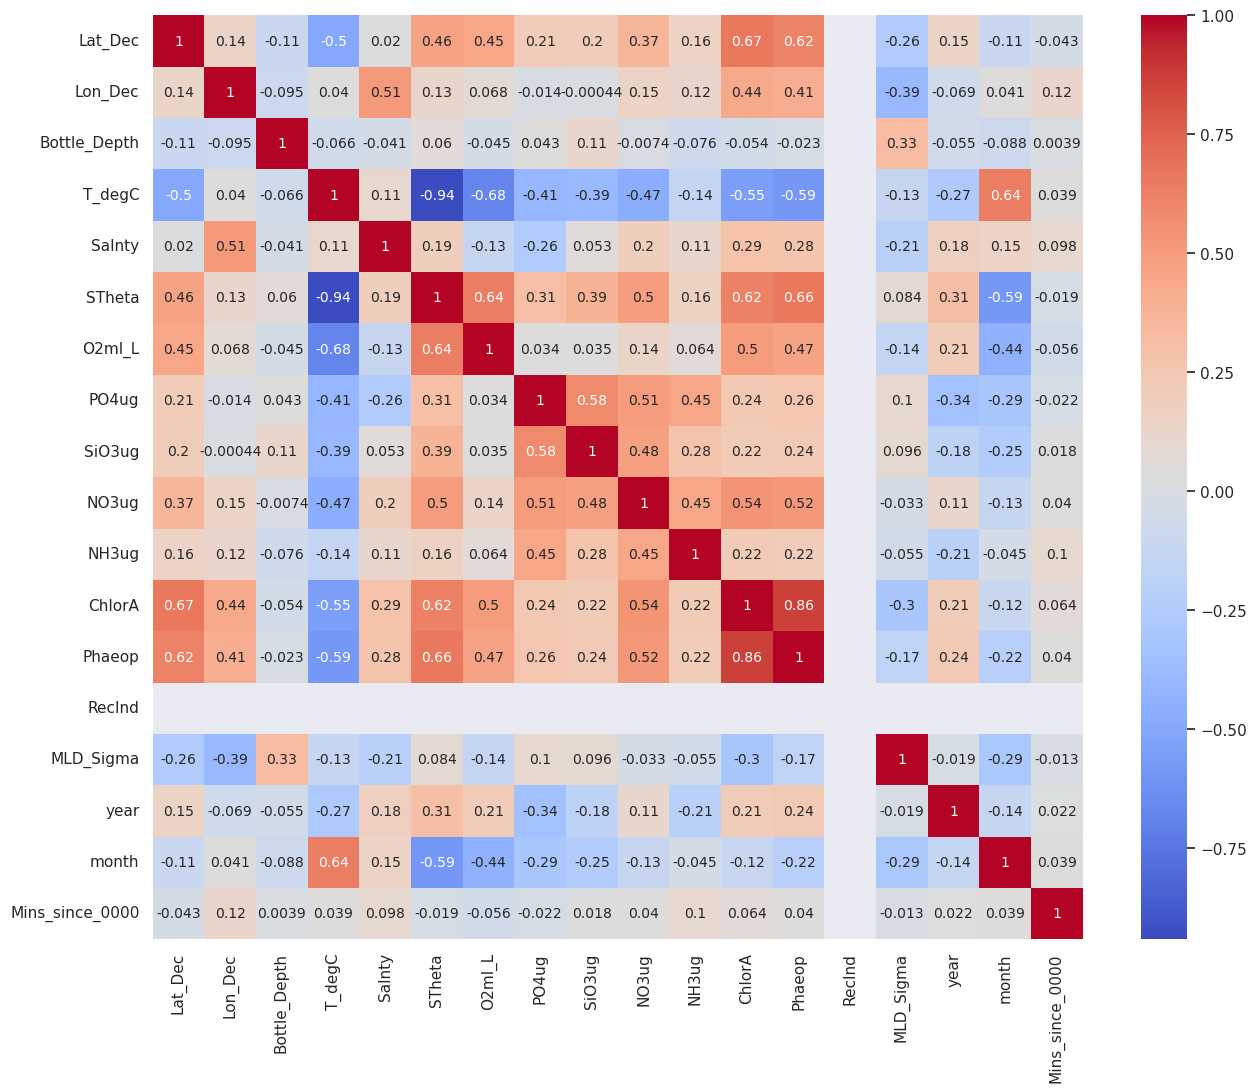

In [16]:
import seaborn as sns
#kendall, spearman both show similar looking graphs
feature_correlations_18Sv4 = MLD_env_features_18Sv4[numerical_env_features].corr(method="spearman")
with sns.set_theme(rc={'figure.figsize':(15,12), 'font.size':10}): #local context
    sns.heatmap(feature_correlations_18Sv4, cmap='coolwarm', annot=True)
feature_correlations_18Sv4.shape

Remove some correlated features, esp those that don't seem helpful: ChlorA and Phaeop (phaeophycin), can remove one of phosphate, silica, or nitrate; remove one of temperature, salinity, or O2?

In [17]:
final_numerical_feature_set = numerical_env_features.drop(["ChlorA", "Phaeop", "RecInd"])
final_numerical_feature_set

Index(['Lat_Dec', 'Lon_Dec', 'Bottle_Depth', 'T_degC', 'Salnty', 'STheta',
       'O2ml_L', 'PO4ug', 'SiO3ug', 'NO3ug', 'NH3ug', 'MLD_Sigma', 'year',
       'month', 'Mins_since_0000'],
      dtype='object')

In [18]:
#removes all rows with nan values
MLD_select_numeric_features_18Sv4 = MLD_env_features_18Sv4[final_numerical_feature_set].dropna()
MLD_select_numeric_features_18Sv9 = MLD_env_features_18Sv9[final_numerical_feature_set].dropna()
MLD_select_numeric_features_18Sv4.shape, MLD_select_numeric_features_18Sv9.shape

((570, 15), (734, 15))

In [19]:
season_onehot_18Sv4 = pd.get_dummies(MLD_env_features_18Sv4["season"], prefix="season")
season_onehot_18Sv9 = pd.get_dummies(MLD_env_features_18Sv9["season"], prefix="season")
#nan values are not given a number
season_onehot_18Sv4.shape, season_onehot_18Sv9.shape

((623, 4), (790, 4))

Final set of predictors: join MLD_select_numeric_features and onehots for each categorical variable.
(don't expect cardinal and cast type to be basis of any splits so leave them out?)

570 obs for 18Sv4, 734 for 18Sv9. could do a 9:1 train test split. 8:2 maybe.

In [20]:
#join right frame onto left frame using left frame index
X_18Sv4 = MLD_select_numeric_features_18Sv4.join(season_onehot_18Sv4, how="left")
X_18Sv9 = MLD_select_numeric_features_18Sv9.join(season_onehot_18Sv9, how="left")
X_18Sv4.shape, X_18Sv9.shape

((570, 19), (734, 19))

Final responses: prune MLD_dino_CM_diatom_difference_18Sv4 with index of X_18Sv4.

In [53]:
#y_18Sv4 = MLD_dino_CM_diatom_difference_18Sv4.loc[X_18Sv4.index]
#y_18Sv9 = MLD_dino_CM_diatom_difference_18Sv9.loc[X_18Sv9.index]

y_18Sv4 = CM_asv_freqs_18Sv4[X_18Sv4.index]
y_18Sv9 = CM_asv_freqs_18Sv9[X_18Sv9.index]

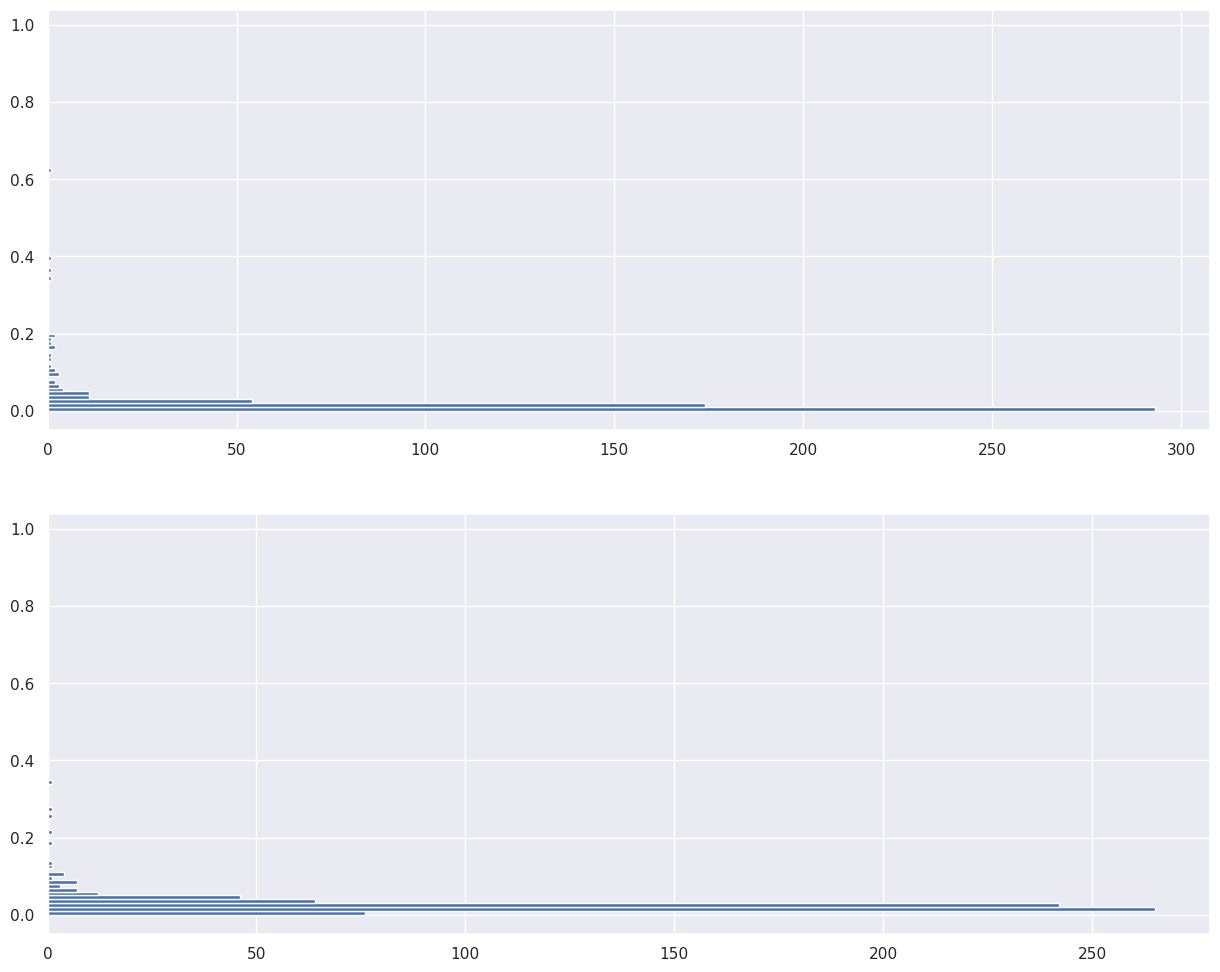

In [63]:
fig, ax = plt.subplots(2,1)
ax[0].hist(y_18Sv4, bins = np.arange(0, 1, 1e-2), orientation = "horizontal", log = False)
ax[1].hist(y_18Sv9, bins = np.arange(0, 1, 1e-2), orientation = "horizontal", log = False)
plt.show()

### Bagging Model: Predict difference of per sample dino-CM and diatom percentages (MLD_dino_CM_diatom_difference_18Sv4, 9) in mixed layer depth samples with environmental variables.

Can we identify environmental types with different properties? (expect that many environments will look exactly the same, since response value close to 0).

**Train test split**

There's 1 feature dataset and 2 response datasets, we're going to use ~20% of the features to test later
Make a selection vector and use it to make Xtrain, Xtest, y1train, y1test, y2train, y2test?

Problem! Say I make an ensemble model fitted to 80% of either response vector. If we're starting with the premise that v4 and v9 offer very different views... which one is actually correct? is the test set just going to be "every single observation twice, except associated with two different responses each time?" what would accuracy on something like that even mean?

it would be one thing to have 2 models where ASV data are predictors and something biogeochemical is the response (bowman)...

In [54]:
X_train_18Sv4, X_test_18Sv4, y_train_18Sv4, y_test_18Sv4 = train_test_split(
    X_18Sv4, 
    y_18Sv4,
    test_size = 0.2, 
    random_state = 0
)

X_train_18Sv9, X_test_18Sv9, y_train_18Sv9, y_test_18Sv9 = train_test_split(
    X_18Sv9, 
    y_18Sv9,
    test_size = 0.2, 
    random_state = 0
)

Tuning number of bagging estimators: is it important? Doesn't seem so, but that's probably more the nature of the data (mostly 0s).

Use 20 estimators, see how results turn out.

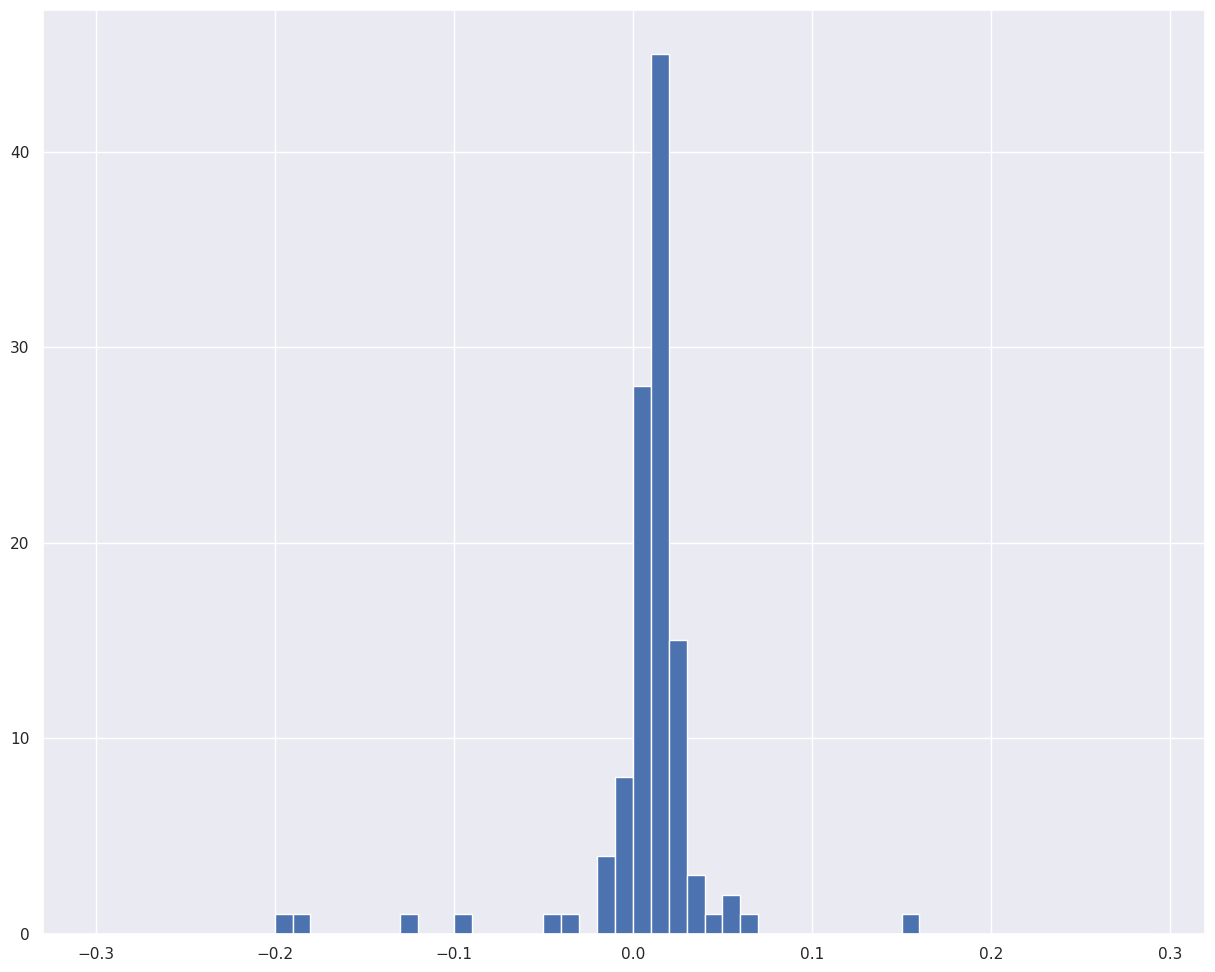

0.0013898093124812504

In [55]:
model_18Sv4 = BaggingRegressor(
    #estimator=DecisionTreeRegressor(), #see if we get better results by stopping splits earlier
    n_estimators = 20,
    random_state=0
).fit(X_train_18Sv9, y_train_18Sv9)

residuals = (model_18Sv4.predict(X_test_18Sv4) - y_test_18Sv4)
fig, ax = plt.subplots()
ax.hist(residuals, bins = np.arange(-.3, .3, 1e-2))
plt.show()

np.mean(residuals ** 2)# ** 0.5

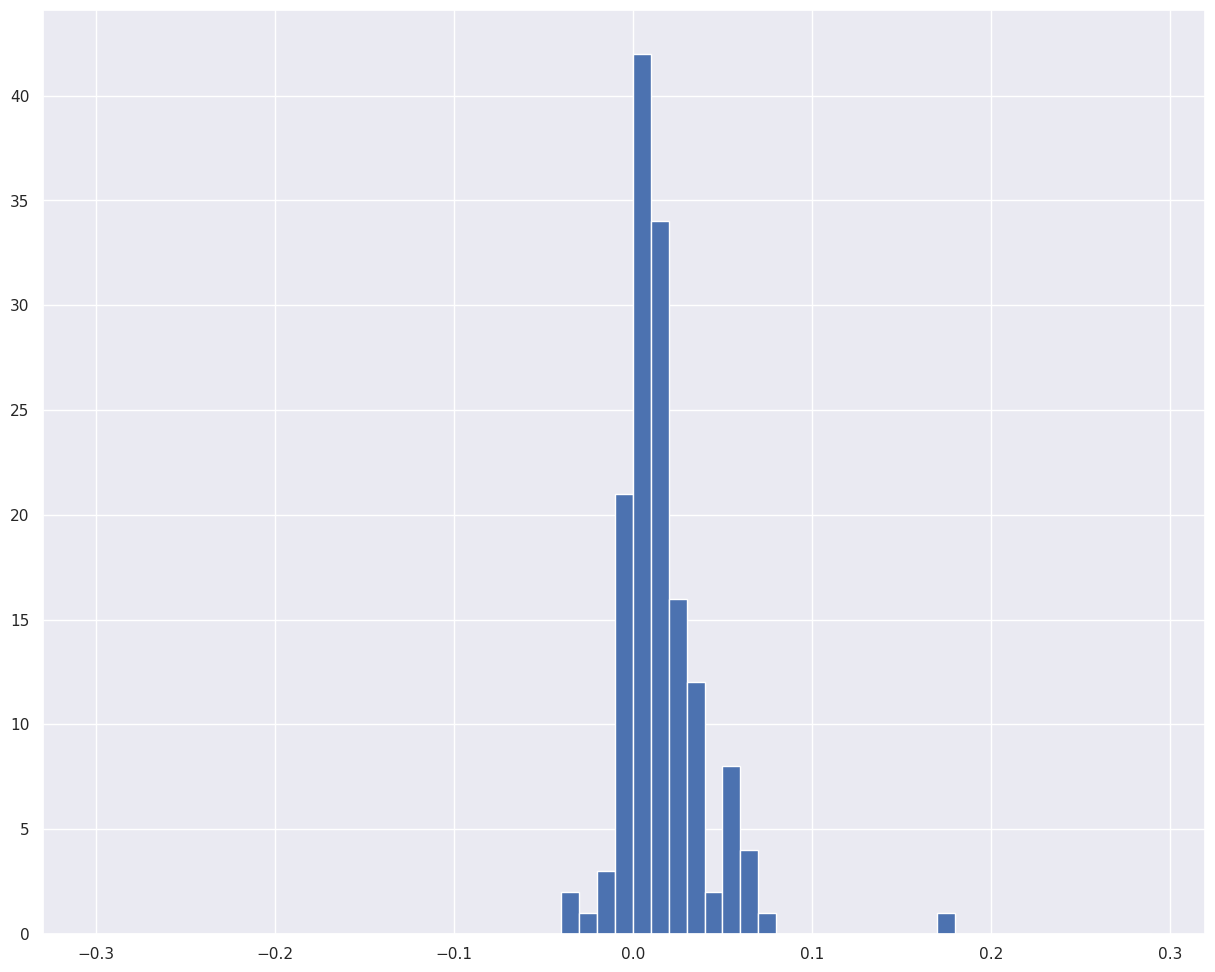

(0.000816583252181283, -0.05710672973840667)

In [56]:
model_env_dino_CM_percent_18Sv9 = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=6), #see if we get better results by stopping splits earlier
    n_estimators = 20,
    random_state=0
).fit(X_train_18Sv9, y_train_18Sv9)

y_pred_18Sv9 = model_env_dino_CM_percent_18Sv4.predict(X_test_18Sv9)
residuals = (y_test_18Sv9 - y_pred_18Sv9)
fig, ax = plt.subplots()
ax.hist(residuals, bins=np.arange(-.3,.3,1e-2))
plt.show()

np.mean(residuals ** 2), np.min(y_pred_18Sv9) #wouldn't expect to go below 0

### Contribution to Reducing SS_residual by Each Variable

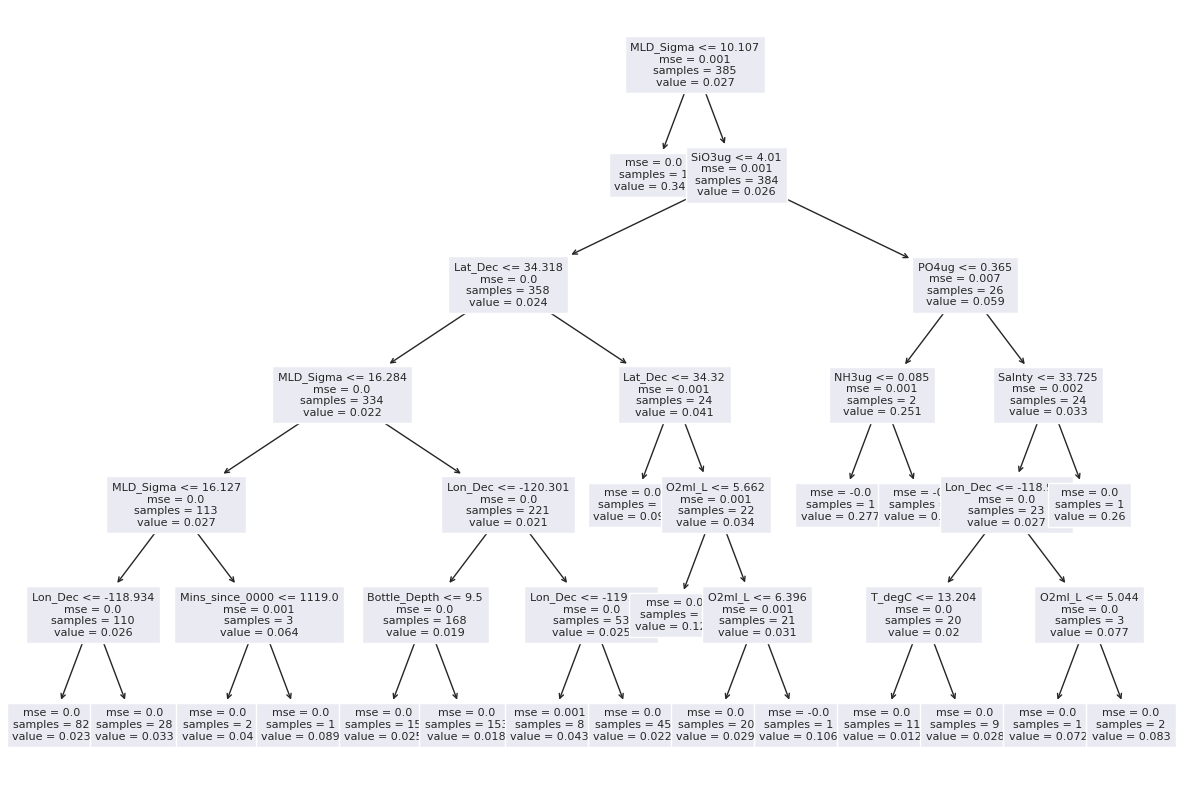

In [57]:
plt.figure(figsize=(15,10))
plot_tree(model_env_dino_CM_percent_18Sv9.estimators_[3],feature_names=X_train_18Sv9.columns, fontsize=8)
plt.show()

In [58]:
#need a way to access every tree and every split, and count the involvement of each feature
#we can see that every estimator was working from the same set of features
model_env_dino_CM_percent_18Sv9.estimators_features_

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 

In [59]:
for estimator in model_env_dino_CM_percent_18Sv9.estimators_:
    #binary tree stored as parallel arrays, each array holds info about ith node (internal or leaf)
    tree = estimator.tree_
    print(tree)
    #every -2 represents a leaf node
    #print(tree.feature)
    #mse is the impurity measure for regression
    #print(tree.impurity)

#a good split will decrease the amount of impurity? not necessarily. might split into a large low mse node
#and a small, high mse node. so they have to be weighted?
#MSE decrease = MSE_parent - sum(MSE_children)
#does not need to be calculated when "MSE parent" would be a leaf node.

In [60]:
total_se_decrease=[0] * X_train_18Sv4.columns.size

for estimator in model_env_dino_CM_percent_18Sv9.estimators_:
    tree = estimator.tree_
    for node_id in range(len(tree.feature)):
        #if this node is a leaf, skip
        feature_id = tree.feature[node_id]
        if feature_id < 0:
            continue
        #if node is not a leaf, find MSE_parent - sum(MSE_children)
        left_child_id = tree.children_left[node_id]
        right_child_id = tree.children_right[node_id]
        SE_parent = tree.impurity[node_id] * tree.n_node_samples[node_id]
        SE_children = (tree.impurity[left_child_id] * tree.n_node_samples[left_child_id]) \
                    + (tree.impurity[right_child_id] * tree.n_node_samples[right_child_id])
        #seems like we can't count on this, a split will choose a bad option even if it's "best"
        #assert(SE_parent >= SE_children)
        #if SE_parent < SE_children:
        #    print(SE_parent, tree.impurity[node_id], tree.n_node_samples[node_id])
        #    print(SE_children, tree.impurity[left_child_id], tree.n_node_samples[left_child_id])
        #    print(tree.impurity[right_child_id], tree.n_node_samples[right_child_id])
        #    print(tree)
        #    assert(False)
        #attribute the MSE decrease to the feature that this node splits on
        total_se_decrease[feature_id] += (SE_parent - SE_children)
        
pd.Series(total_se_decrease, index=X_train_18Sv9.columns).sort_values(ascending=False)

MLD_Sigma          1.985772
Salnty             0.436398
Lat_Dec            0.395671
O2ml_L             0.379676
T_degC             0.228387
PO4ug              0.218576
SiO3ug             0.168960
Lon_Dec            0.158331
Bottle_Depth       0.140270
month              0.125300
NH3ug              0.100884
STheta             0.068968
season_summer      0.062274
year               0.058565
Mins_since_0000    0.045256
NO3ug              0.009825
season_fall        0.005572
season_spring      0.002555
season_winter      0.001306
dtype: float64